![banner](./images/banner.png "banner")

[Fuente de la imagen](https://unsplash.com/photos/Hcfwew744z4)
<a name='toc' />

# <font color=#ac6240>Explicabilidad de la predicción de fallo cardíaco con aprendizaje automático supervisado</font>

### <font color=#ac6240>Tabla de Contenidos</font>

<a href=#pre>Requisitos previos</a><br>
1. <a href=#project-description>Descripción del proyecto</a><br>
    1.1 <a href=#project-description-intro>Introducción</a><br>
    1.2 <a href=#project-description-goal>Objetivo</a><br>
    1.3 <a href=#project-description-data>Datos y modelo de aprendizaje automático</a><br>
    1.4 <a href=#project-description-software>Software</a><br>
2. <a href=#prep>Preparación de los datos</a><br>
    2.1 <a href=#prep-clean> Limpieza de los datos</a><br>
    2.2 <a href=#prep-split> Division de los datos en conjuntos de datos de entrenamiento, validación y prueba</a><br>
    2.3 <a href=#prep-encoding> Codificación y normalización de las 'features'</a><br>
3. <a href=#model-ml>Aplicación del modelo de aprendizaje automático: Bosque Aleatorio</a><br>
    3.1 <a href=#model-metric> Selección de la métrica y del umbral de decisión </a><br>
    3.2 <a href=#model-RF> Entrenamiento, prueba, y aplicación del bosque aleatorio </a><br>
4. <a href=#xai-app>Aplicación de métodos de explicabilidad</a><br>
    4.1 <a href=#xai-per> Permutacion Feature Importance, Parcial Dependence Plots, e Individual Conditional Expectations</a><br>
    4.2 <a href=#xai-shap> SHAP </a><br>
    4.3 <a href=#xai-lime> LIME </a><br>
    4.4 <a href=#xai-counterfact> Counterfactual Explanations</a><br>
5. <a href=#xai-end>Conclusión sobre los métodos de explicabilidad</a><br>

<a name='pre'/>

## <font color=#ac6240>Requisitos previos</font>

Este Jupyter Notebook es la continuación del Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI). En ese otro estudio explicamos cómo explorar exhaustivamente los datos y cómo evaluar la calidad de un modelo. Para esto último utilizamos métricas de rendimiento o desempeño sobre varios modelo de aprendizaje automático supervisado y elegimos el que mejor se comportaba para este proyecto de predicción de fallo cardíaco.

<font size="5"> 👍🤓 </font>

<a name='project-description'/>

##  <font color=#ac6240>1. Descripción del proyecto</font>

<a name='project-description-intro'/>

### <font color=#ac6240>1.1 Introducción</font>

Una vez un modelo de aprendizaje automático está entrenado y nos da como resultado sus predicciones con un gran desempeño (por ejemplo, hemos logrado una 'accuracy' del 98% en la validación y el testing) a menudo es fundamental entender en qué se fijó el modelo para hacer tales predicciones. Esto nos asegura que se llevó a cabo la tarea que deseamos y no otra. Por ejemplo, si estamos clasificando fotos de animales para distinguir lobes de perres Husky con una [red neuronal artificial](https://es.wikipedia.org/wiki/Red_neuronal_artificial), es decir, una 'black-box' o caja opaca, es importante comprobar que el modelo identificó a une lobe por su forma, y no porque hizo trampas y descubrió que le era más fácil comprobar si había o no nieve al fondo de la foto, ya que la gran mayoria de las fotos de lobes de los datos de entrenamiento estaban en la nieve:

![lime_snow](./images/lime_snow_husky.png "lime_snow")

[Fuente de la imagen: _"'Why Should I Trust You?': Explaining the Predictions of Any Classifier"_](https://dl.acm.org/doi/10.1145/2939672.2939778)

Esto es fundamental porque probablemente cuando apliquemos el modelo de aprendizaje automático en la vida real, las nuevas fotos que vea el modelo pueden ser de perres Huskies en la nieve o de lobes en la playa y por lo tanto ese modelo, por muy exacto ('accurate') que sea, será completamente inútil. 

#### <font color=#ac6240>1.1.1 Qué es la explicabilidad</font>

Un cambio inesperado e indeseado de tarea (en el ejemplo anterior, queríamos un modelo que identificara animales, no el fondo de la foto) puede pasar desapercibido, sobre todo si el modelo no es interpretable por las personas (las redes neuronales que se utilizan para clasificar imagenes son cajas opacas con cientos de hiperparámetros irrastreables). Para evitar que esto ocurra podemos aplicar técnicas de explicabilidad, también conocidas como [XAI](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence), sobre los resultados del modelo y comprobar, por ejemplo, si durante el entrenamiento hubo percolaciones de información indeseadas, un fenómeno llamado [leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning). Un ejemplo de "leakage" fue mencionado en el README.md: una red neuronal muy precisa había detectado el atajo de buscar las marcas que inintencionadamente tenían las radiografías cuando se había realizado en la planta UCI y ese factor circunstancial era el que primaba en su predicción ["AI for radiographic COVID-19 detection selects shortcuts over signal"](https://www.nature.com/articles/s42256-021-00338-7). 

Es decir, podemos aplicar métodos de XAI a los resultados de un modelo de aprendizaje automático ya entrenado para ver qué datos afectan a dichos resultados (y por lo tanto fueron importantes para el modelo) y cuáles no. Es importante resaltar que una variable puede ser importante para un modelo pero para otro no, es decir, los métodos de XAI no nos dan el poder predictivo de las variables de manera absoluta, si no de manera relativa respecto a ese modelo de aprendizaje automático que nos dió ese resultado.

En la figura anterior, vemos la aplicación del método de XAI llamado "Local Interpretable
Model-agnostic Explanations" ([LIME](https://github.com/marcotcr/lime)) que descubrió que el modelo de clasificación de imágenes no se fijaba en le perre Husky sino en la nieve al fondo, muy loco.

<font size="5">🤪</font>

#### <font color=#ac6240>1.1.2 Algunas definiciones sobre explicabilidad</font>

#### <font color=#ac6240>Modelos opacos o 'Black-box models'</font>

No son modelos de aprendizaje automático interpretables, las personas no pueden comprender las causas de las decisiones porque (i) conocer los valores de los parámetros e hiperpárametros de una 'black-box' no es suficiente para inferir qué es lo que ocurre dentro o (ii) las asunciones y limitaciones subyacentes del modelo de aprendizaje automático son desconocidas. Ejemplos de modelos opacos son: los bosques aleatorios y sus versiones secuenciadas y aceleradas ('gradient-boosted') y todas las redes neuronales.


#### <font color=#ac6240>Modelos explicables</font>

Aún son modelos de aprendizaje automático opacos, no interpretables, pero con algunos métodos de explicabilidad (XAI) intentamos entender de dónde vienen las prediciones y por qué el modelo de apredizaje automático tomó esas decisiones y no otras. Estas técnicas de XAI pueden aplicarse a cualquier modelo de aprendizaje automático supervisaso y se aplican una vez el modelo principal ya está entrenado. Ejemplos de métodos de XAI populares y que veremos aquí son: [SHAP](https://github.com/slundberg/shap) y [LIME](https://github.com/marcotcr/lime) (este último ya lo mencionamos en la introducción). 

Es importante resaltar que estos métodos de XAI no son la panacea porque:

   1. traen sus propias asunciones y limitaciones,
   2. introducen nuevas incertidumbres/errores, 
   3. pueden ser engañados, y
   4. puede ocurrir que discrepen entre ellos, 

por lo tanto, siempre es preferible elegir un modelo interpretable o 'glass-box model'.
    
#### <font color=#ac6240>Modelos caja de cristal o 'Glass-box models'</font>

Las personas pueden interpretar los resultados de estos modelos de aprendizaje automático y entender las causas de las decisiones conociendo los valores de los hiperpárametros del modelo y además las asunciones y limitaciones subyacentes del modelo son conocidas. Ejemplos de modelos de aprendizaje automático interpretables son: la regresión linear, la regresión logística, los árboles de decisión, el naive Bayes, y el k-nearest neighbors. También podemos aplicar métodos de XAI a los resultados de estos modelos porque como veremos a continuación, los métodos de XAI no solo sirven para entender predicciones sino que nos ayudan en todo el proceso de la obtención de información a partir de datos.

#### <font color=#ac6240>1.1.3 Algunas ventajas de la explicabilidad</font>

#### <font color=#ac6240>Ética</font>

+  La explicabilidad es esencial para evitar predicciones sesgadas ('biased'); tener un conjunto de datos de entrenamiento de calidad y de gran volumen es primordial, pero no suficiente, hemos de estar alerta y vigilar la componente humana y para quien piense que es une programadore neutral y no tiene prejuicios, ver por ejemplo esta [lista de 50 sesgos que todes tenemos las personas](https://www.visualcapitalist.com/50-cognitive-biases-in-the-modern-world/) o [en castellano](https://ceciliacorespsicologa.es/50-sesgos-cognitivos/); damos una definición formal al concepto de sesgo en el Jupyter Notebook `UQ.ipynb` de este mismo repositorio.

+ Los modelos de aprendizaje automático supervisado implementados y desplegados sufren [Performative prediction](https://arxiv.org/pdf/2002.06673v1.pdf) cuando sus predicciones afectan a sus futuros 'inputs'. Por ejemplo, cuanto más gente escucha solo las canciones que Spotify recomienda, el rendimiento del algoritmo de Spotity a medida que se reentrena es cada vez mejor pero porque ha condicionado a les oyentes y ha provocado una nueva distribución de los gustos de diches oyentes. En otras palabras, con el paso del tiempo el aprendizaje automático puede convertir nuestras decisiones en meros ecos de las decisiones pasadas y los datos futuros en réplicas de los datos historicos. Necesitamos análisis de explicabilidad y ética para lidiar con esto.

#### <font color=#ac6240>Legalidad</font>

La explicabilidad nos permite estar al día con la legalidad en un intento de lidiar con los problemas que están causando el uso de las 'black-boxes' (ver referencias aquí abajo):
+ La General Data Protection Right [GDPR](https://en.wikipedia.org/wiki/General_Data_Protection_Regulation) introducida por la EU en 2018 que incluye el [derecho a la explicación](https://en.wikipedia.org/wiki/Right_to_explanation).
+ El reglamento europeo (conocido como [The AI Act](https://digital-strategy.ec.europa.eu/en/policies/regulatory-framework-ai)), en vigor desde el 1 de Agosto de 2024, que obliga a las entidades públicas y privadas a explicar sus algoritmos de aprendizaje automático, y que exige que los Estados miembros designen autoridades nacionales para vigilar su cumplimiento y cuyo principal el objetivo es que los algorithmos sean confiables ("trustworthy IA"):

        "The AI Act (Regulation (EU) 2024/1689 laying down harmonised rules on artificial intelligence)is the first-ever comprehensive legal framework on AI worldwide. The aim of the rules is to foster trustworthy AI in Europe".

Más info en [Connecting the Dots in Trustworthy Artificial Intelligence: From AI Principles, Ethics, and Key Requirements to Responsible AI Systems and Regulation"](https://arxiv.org/pdf/2305.02231.pdf). Como indica Natalia Díaz Rodríguez, premera autora del artúcilo, en [esta entrevista](https://www.ideal.es/ciencia/productos-inteligencia-artificial-20221219233934-nt.html), la regulación asegura que los modelos de IA vengan con prospecto, como los medicamentos, con sus contraindicaciones y sus efectos secundarios. 

#### <font color=#ac6240>Calidad</font>

+ Con explicabilidad detectamos si el modelo de aprendizaje automático realiza la tarea deseada o por el contrario hay [leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning), como mencionamos más arriba.
+ La explicabilidad es en sí misma un [análisis de sensibilidad](https://en.wikipedia.org/wiki/Sensitivity_analysis) porque principalmente se basa en recalcular los resultados del modelo sobre perturbaciones de las 'features' (es decir, se basa en simular de diferentes maneras nueves pacientes) y poder así determinar el impacto de dichas alteraciones; aplicando XAI generamos modelos robustos y resilientes porque nos hemos anticipado a posibles problemas que puedan aparcer en el futuro, por ejemplo, ['concept drift'](https://en.wikipedia.org/wiki/Concept_drift) o ['data drift'](https://en.wikipedia.org/wiki/Drift_(data_science); más info sobre la definición y sus diferentes tipos, [aquí](https://analyticsindiamag.com/concept-drift-vs-data-drift-in-machine-learning/).
+ Todos los modelos de aprendizaje automático supervisado están diseñados para interpolar, no para extrapolar, y por tanto no generalizan bien ni pueden abstraer conocimiento ni entienden de relaciones causa-ejecto, pero aplicando métodos de explicabilidad podemos identificar mejor esas limitaciones.
+ La explicabilidad nos ayuda a identificar y solucionar errores de programación (['debugging'](https://es.wikipedia.org/wiki/Depuraci%C3%B3n_de_programas)).

#### <font color=#ac6240>Valor añadido</font> 

+ La explicabilidad identifica qué características (y qué valores de dichas características) son las que más contribuyen en las predicciones del modelo, así desglosamos los factores más relevantes para el proceso al que aplicamos el aprendizaje automático y lo conoceremos mejor.
+ La explicabilidad es esencial para comprobar que el modelo es consistente con las restricciones físicas, económicas, ... del problema (por ejemplo, para comprobar que se cumplen las leyes de conservación de la energía y la masa, limitaciones de presupuesto,...); [aqui](https://arxiv.org/pdf/1710.11431.pdf) un ejemplo de un modelo aprendizaje automático de hidrología que arrojaba soluciones que violaban las relación densidad-profundidad del agua y permitían que agua líquida más densa flotara sobre agua líquida menos densa (si es que si no se lo dices, eso al algoritmo le da igual).

#### <font color=#ac6240>Practicabilidad</font>

+ La explicabilidad se puede aplicar a cualquier modelo de aprendizaje supervisado sin tener que volver a entrenarlo.
+ La explicabilidad está ya implementada en librerías compatibles, extensibles, y escalables para los 'frameworks' más populares (Scikit-learn, Tensorflow, Pytorch,...).

#### <font color=#ac6240>Ecología</font>

La explicabilidad nos ahorra energía porque entrenar los grandes modelos que usamos a diario es medioambientalmente muy muuuuuy costoso y nos ahorra tiempo porque cuánto antes se hagan las cosas bien, mejor.

+ el artículo [Descifrando el consumo de agua de la IA: así oculta Amazon cuánto bebe su nube en España](https://elpais.com/tecnologia/2025-03-07/descifrando-el-consumo-de-agua-de-la-ia-asi-oculta-amazon-cuanto-bebe-su-nube-en-espana.html)

+ el artículo [AI already uses as much energy as a small country.](https://www.vox.com/climate/2024/3/28/24111721/ai-uses-a-lot-of-energy-experts-expect-it-to-double-in-just-a-few-yearhttps://www.vox.com/climate/2024/3/28/24111721/ai-uses-a-lot-of-energy-experts-expect-it-to-double-in-just-a-few-year`s)


#### <font color=#ac6240>Certeza</font>

+ La explicabilidad aporta datos convincentes para presentar a las partes interesadas ('stakeholders', inversores, revisores, clientes, usuaries...)
+ La explicabilidad hace un poquito más transparentes a las cajas opacas, yo por lo menos, duermo mejor.

<font size="5"> 🙂 </font>

<font color=#6B8E23 size="4"> Material adicional y referencias</font>

<font color=#6B8E23 size="3">Ejemplos de los peligros de la automatización de decisiones</font>

+ La espectacular charla del gran Vincent Warmerdamm ['How to constrain artificial stupidity'](https://youtu.be/Z8MEFI7ZJlA).
+ El libro _'Weapons of math destruction'_ de Cathy O'Neil, hay [versión en castellano](https://www.indienauta.com/armas-destruccion-matematica-cathy-oneil-capitan-swing-2018/)
+ La keynote de [Mai Giménez](https://2022.es.pycon.org/pages/mai.html) y la charla de [Víctor Vicente](https://charlas.2022.es.pycon.org/pycones2022/talk/SMWW7F/) en la PyConES22 en la lista de reproducción del canal de Youtube de Python España.

<font color=#6B8E23 size="3">Conceptos de XAI y código</font>

+ El maravilloso libro gratuito de Christopher Molnar [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/).
+ [Micro curso de explicabilidad en 4h](https://www.kaggle.com/learn/machine-learning-explainability) de Kaggle.
+ [A Comprehensive Guide to Explainable AI: From Classical Models to LLMs](https://arxiv.org/abs/2412.00800)
+ En la PyConES 2022 tenemos una charla sobre los explicabilidad que nos trae [Bea Hernández](https://charlas.2022.es.pycon.org/pycones2022/talk/3TKTHE/) _"Explicabilidad local: ¿cómo interpreto la predicción?"_, co-desarrolladora de una librería de Python para implementar XAI en Gradient Boosting Machines, que puede verse en la lista de reproducción del canal de youtube de Python España.

<font color=#6B8E23 size="3">Sobre los problemas de la XAI</font>

+ El genial vídeo de la gran Cynthia Rudin ['Please stop using explainable ML'](https://youtu.be/I0yrJz8uc5Q) o su artículo en Nature [Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead](https://www.nature.com/articles/s42256-019-0048-x).
+ Ejemplos de engaño a modelos de XAI: el artículo [Fooling LIME and SHAP: Adversial Attacks on post hoc explanation methods](https://dl.acm.org/doi/pdf/10.1145/3375627.3375830) y la 
charla de NeurIPS 2021 [Counterfactual Explanations Can Be Manipulated](https://youtu.be/q-7LB3I4PyU).
+ Los artículos ["Do Not Trust Additive Explanations"](https://arxiv.org/abs/1903.11420) y ["On the failings of Shapley values for explainability"](https://www.sciencedirect.com/science/article/abs/pii/S0888613X23002438).
+ Qué hacer si aplicas varios métodos de XAI y sus conclusiones discrepan: [_"The Disagreement Problem in Explainable Machine Learning: A Practitioner's Perspective"_](https://arxiv.org/abs/2202.01602).
+ Sobre  [conformalizar los valores de Shapley](https://raw.githubusercontent.com/mlresearch/v230/main/assets/alkhatib24a/alkhatib24a.pdf), veremos qué es la conformalización en el siguiente notebook sobre Cuantificación de Incertidumbre `UQ.ipynb` en este mismo repositorio. 


<font color=#6B8E23 size="3">Recopilación de métodos de XAI</font>

+ El tutorial ["A Practical Tutorial on Explainable AI Techniques"](https://www.researchgate.net/publication/356631645_A_Practical_Tutorial_on_Explainable_AI_Techniques"), la super completa charla ["XAI: Concepts, Taxonomies, Opportunities and Challenges toward Responsible AI"](https://youtu.be/UcN7tRvXxmI), y [este resumen del ecosistema XAI, también para redes neuronales y Reinforcement Learning](https://es.wikipedia.org/wiki/Aprendizaje_por_refuerzo), todo de Natalia Díaz Rodríguez y colaboradores. 

+ La librería [AIF360](https://github.com/Trusted-AI/AIF360) de IBM con varias técnicas para detectar y mitigar sesgos en modelos de aprendizaje automático u otras librerias parecidas como las recopiladas en [este post](https://www.linkedin.com/posts/maryammiradi_machinelearning-artificialintelligence-ai-activity-7025773739229224960-HQdC)


![books](./images/books.png "books")

<a name='project-description-goal'/>

### <font color=#ac6240>1.2 Objetivo</font>

En este Jupyter Notebook vamos a aplicar algunas técnicas de XAI a los resultados del modelo de bosque aleatorio (que no es interpretable) que entrenamos en el Jupyter Notebook `Exploration_and_Classification.ipynb`. No incluimos explicaciones exhaustivas y demostraciones matemáticas (hay muchas otras fuentes, ver la lista de materiales arriba), mejor mencionaremos algunas características intuitivas sobre explicabilidad y nos enfocaremos en su implementación en Scikit-learn.

Si ya conoces ese Jupyter Notebook anterior, ya estarás familiarize con los datos y con el bosque aleatorio que seleccionamos como modelo ganador, así que puedes pasar directamente a la sección <a href=#app-xai> 4. Aplicación de métodos de explicabilidad</a>.

<a name='project-description-data'/>

### <font color=#ac6240>1.3 Datos y modelo de aprendizaje automático</font>

Utilizaremos los datos y el modelo de aprendizaje automático del Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI).

**Datos**

Los datos que ya exploramos y preparamos son el [Conjunto de datos de predicción de insuficiencia cardíaca de Kaggle](https://www.kaggle.com/fedesoriano/heart-failure-prediction) (cita: fedesoriano. (Septiembre de 2021) Heart Failure Prediction Dataset), y

Recordamos que las 'features' o características son los datos de les pacientes ('Age', 'Cholesterol',...) y la variable objetivo o 'target', es decir, lo que queremos predecir, se llama "HeartDisease", y es una variable binaria que toma los valores:
+ 1: sí, pacientes que sí presentan riesgo de padecer una cardiopatía
+ 0: no, pacientes que no presentan riesgo de padecer una cardiopatía

En relacion a la 'feature' 'Sex', vamos a interpretar que se refiere al sexo con el que nacieron esas personas. Por otro lado vemos que solo toma los valores 'M' (male) or 'F' (female), es decir, entendemos que no hay datos de personas intersexuales o no binarias.

**Modelo de aprendizaje automático para la clasificación**

El modelo de clasificación que utilizaremos es un bosque aleatorio que ya ajustamos, entrenamos, y validamos en el Jupyter Notebook anterior. En este Jupyter Notebook directamente dividiremos el conjunto de datos en datos de entrenamiento y datos de prueba ('test'). Sobre esos datos de prueba aplicaremos el modelo de aprendizaje automático en la sección <a href=#model-ml>3. Aplicación del modelo de aprendizaje automático: Bosque Aleatorio</a>.

Para cada nueve paciente, el modelos supervisado del bosque aleatorio anteriormente entrenado, al aplicar `.predict_proba()` nos da una puntuación o 'raw score' que si esta cerca de '0' clasifica a ese paciente en el grupo de pacientes sin riesgo a sufrir fallo cardíaco y si esta cerca de '1' clasifica a ese paciente en el grupo de pacientes sin riesgo a sufrir fallo cardíaco (donde 'cerca' se define por el 'umbral de decisión' como explicamos en el anterior Jupyter Notebook `Exploration_and_Classification.ipynb`, sección 4. Entrenamiento de los modelos). A menudo se toma esa 'raw score' como probabilidad heurística (como mencionamos en el ese primer Jupyter Notebook) de que ese nueve paciente esté o no en riesgo de sufrir una insuficiencia cardíaca. Si por ejemplo une nueve paciente puntúa 0.7, con el umbral de decisión igual a 0.4 (valor que elegimos porque optimizaba la metrica de rendimiento F1 para tener en cuenta la reduccion de Falsos Negativos), le paciente quedará clasificade como 'perteniente al grupo en riesgo de sufrir fallo cardíaco' pero eso no necesariamente significa que tenga un 70% de probabilidad de sufrir fallo cardíaco porque el modelo clasificador no viene calibrado por defecto (explicaremos el concepto de calibración en el siguiente Jupyter Notebook sobre cuantificacion de incertidumbre `UQ.ipynb`). 

Y volvemos a remarcar que nuestro modelo solo es bueno encontrando correlaciones, espurias o no, y ni generaliza, ni entiende de relaciones de causa-efecto, ni conoce las restricciones del problema,... por eso es fundamental que las decisiones finales sean tomadas por personas expertas en medicina.  

![ivory](./images/ivory_small.png "ivory")

[Fuente de la imagen: "Mean-squared-terror"](https://koaning.io/posts/mean-squared-terror/)

Como es claramente una decisión de vida o muerte y como el bosque aleatorio no es un modelo interpretable, aplicaremos métodos de XAI para ver en qué variables se fijó el modelo de aprendizaje automático para hacer su predicción y evitar 'leakage', sesgos, y los otros problemas que mencionamos anteriormente. Lo haremos en la siguiente sección <a href=#xai-app>4. Aplicación de métodos de explicabilidad </a>.

Hemos elegido trabajar sobre un conjunto de datos tabulares porque los modelos de aprendizaje automático y los métodos de XAI suelen ser más fáciles de entender si podemos ver las 'features' en columnas. Sin embargo los métodos de XAI que explicamos aquí sirven en su mayoría para cualquier aplicación mientras sea de aprendizaje supervisado. No cubriremos aquí métodos de XAI específicos para modelos de aprendizaje automático basados en redes neuronales como el método llamado "Layer-wise Relevant Propagation", [LRP](https://github.com/atulshanbhag/Layerwise-Relevance-Propagation), y el 'framework' [Quantus](https://github.com/understandable-machine-intelligence-lab/Quantus/blob/main/README.md) desarrollado por el mismo grupo que diseño el método LRP. Tampoco usaremos otros 'frameworks' como [AIX 360](http://aix360.mybluemix.net/) de IBM, plataformas como [H2O](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html), o 'wrappers' como [interpret](https://github.com/interpretml/interpret). Nos limitaremos a implementar directamente librerías de Scikit-learn o compatibles con Scikit-learn.

<a name='project-description-software'/>

### <font color=#ac6240>1.4 Software</font>

In [1]:
# Libraries to install if not done before, restart kernel after installation
#!pip install shap
#!pip install lime
#!pip install dice_ml

Importamos las siguientes librerías:

In [2]:
import pandas as pd     
import numpy as np

# data exploration and preparation  
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer 
from sklearn.preprocessing import StandardScaler 

# model
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# XAI methods
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import shap 
import lime
import dice_ml as dice


# model evaluation
from sklearn.metrics import accuracy_score, f1_score, auc, recall_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score


# plotting and displaying in the notebook
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
import emoji

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/home/maria/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a href=#toc>Subir a la Tabla de Contenidos</a><br>

<a name='prep'/>

## <font color=#ac6240>2. Preparación de los datos</font>

La exploración y preparación de los datos se hizo en el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI), aquí solo mostarmos los pasos esenciales.

<a name='prep-clean'/>

### <font color=#ac6240>2.1 Limpieza de los datos</font>

Cargamos los datos del fichero que esta en el mismo repositorio:

In [3]:
df = pd.read_csv("data/heart_failure.csv")
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

'FastingBS' (la presión sanguínea en ayunas) debería ser una variable categórica ya que los valores actuales de '0' y '1' son solamente representaciones de valores cualitativos que no queremos que el modelo interprete como valores cuantitativos.

In [4]:
# Transform the categorical values wrongly classified as numericals
new_values = {
    0: 'L', # low
    1: 'H', # high
}

df.FastingBS = df.FastingBS.map(new_values)
# type(df.FastingBS[0]) # uncomment to check that it is a string type

In [5]:
# Store in different lists the names of the categorical and numerical columns since they will be treated different 
categorical = df.select_dtypes(include=['object']).columns.tolist()  # for strings 
numerical = df.select_dtypes(include=['int64','float64']).columns.tolist() # for numbers

Los valores mínimos de 'RestingBP' y 'Cholesterol' son cero, lo cual es sospechoso. Con experiencia en el campo de la medicina, podríamos decidir si reemplazar estos valores nulos por la media u otro valor. Carecemos de esta información, por lo tanto, simplemente eliminamos esas filas.

In [6]:
index_to_drop = list(df.loc[(df.RestingBP == 0) | (df.Cholesterol == 0)].index)
df.drop(index_to_drop, inplace=True)

<font size ='5'> ✌️ </font>No hay necesidad de más limpieza de datos.

<a name='prep-split'/>

### <font color=#ac6240>2.2 División de los datos en conjuntos de datos de entrenamiento, validación y prueba</font>

En esta división aleatoria, y en todas las ocasiones siguientes en las que usemos un generador de números aleatorios, fijamos la semilla del generador de números aleatorios para asegurar la reproducibilidad de los resultados. Fijamos el `random_state = 1` pero podría ser 2 o cualquier otro valor, no afectará significativamente a las predicciones, pero con esta corrección siempre obtendremos exactamente los mismos resultados.

Recordamos que dividimos el conjunto de datos en entrenamiento y prueba porque la exploración de los datos y el ajuste y la validación del modelo de clasificación ya lo hicimos en el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI).

In [7]:
# copy the original dataframe so further manipulations will not affect it 
df_select = df.copy() 
categorical = df_select.select_dtypes(include=['object']).columns.tolist()
numerical = df_select.select_dtypes(include=['int64','float64']).columns.tolist()
numerical.remove('HeartDisease')

In [8]:
numerical

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [9]:
# first separate the train from the test set
df_train, df_test = train_test_split(df_select, test_size=0.2, random_state=1)
len(df_train), len(df_test)

(596, 150)

In [10]:
# reset index
df_train = df_train.reset_index(drop=True)
# define the target
y_train = df_train.HeartDisease.values
# remove the target from the features
del df_train['HeartDisease']

<a name='prep-encoding'/>       

### <font color=#ac6240>2.3 Codificación y normalización de las 'features'</font>

Para codificar las características categóricas usamos Scikit-Learn `DictVectorizer`, que toma un diccionario y lo convierte en un vector, es decir, en un` numpy.array`. Es un método de los llamados One-Hot Encoding (OHE) para convertir las características categóricas (no afectaría las numéricas si se lo aplicasemos) en columnas con valores binarios, con tantas columnas como valores tome la variable categórica. Por ejemplo, la columna de la caracteristíca 'ExcerciseAngina' que podía tener valores 'N' o 'Y' ahora dará lugar a dos columnas, una llamada 'ExcerciseAngina=N' y otra 'ExcerciseAngina=Y' que claramente son dependientes (dan la misma información) y están totalmente correlacionadas (cuando el valor de una es '0', el valor de la otra es seguro '1', ver las correlaciones en el Jupyter Notebook anterior). Cualquier método de codificación añade por tanto información redundante. Hemos de eliminar la información redundante desechando una de las columnas de cada par correlacionado (da igual qué columna de cada par eliminemos, ambas dan la misma información), quitaremos 'ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up':

In [11]:
dv = DictVectorizer(sparse=False) # False bcs is not a sparse matrix (we do not have many zeros)

# TRAIN
train_dict = df_train[categorical].to_dict(orient='records') # records = to do it row-wise, not col-wise
X_train_cat = dv.fit_transform(train_dict) # make it a vector

df_X_train_cat = pd.DataFrame(X_train_cat,columns= dv.get_feature_names_out())
# remove redundant columns
df_X_train_cat.drop(['ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up'], 
                    axis=1, inplace=True)
# convert the dataframe to a np.array again
X_train_cat = df_X_train_cat.to_numpy()

categorical_update = df_X_train_cat.columns.to_list()

En el Jupyter Notebook de la exploración y clasificación de los datos usamos Scikit-Learn `StandardScaler` para normalizar las características numéricas entre 0 y 1. Así, aquellas columnas con valores en un rango más alto no tendrían más representación y modelos como la regresión logística convergían mejor. Como aquí usamos un bosque aleatorio, no necesitamos escalar las 'features' numéricas. De hecho, la librería para calcular las 'counterfactual explanations' (ver sección <a href=#xai-app>4. Aplicación de métodos de explicabilidad </a>) sobre datos escalados se bloqueaba en un 'loop' infinito probablemente provocado por un ratio de cambio demasiado pequeño o incluso cero para números muy pequeños.  Las librerías 'SHAP' y 'LIME' que veremos en esa sección también, aplican sus propias normalizaciones. Depués de comprobar que los resultados para el resto de métodos de XAI son iguales si los aplicamos a datos numéricos escaleados o no escaleados, decidimos omitir el escaleo.

In [12]:
#scaler = StandardScaler()

# TRAIN
X_train_num = df_train[numerical].values
#X_train_num = scaler.fit_transform(X_train_num)

Unimos las matrices numéricas y categóricas:

In [13]:
# TRAIN
X_train = np.column_stack([X_train_num, X_train_cat])

Las nuevas características son:

In [14]:
feature_names = numerical + categorical_update
feature_names

['Age',
 'RestingBP',
 'Cholesterol',
 'MaxHR',
 'Oldpeak',
 'ChestPainType=ASY',
 'ChestPainType=ATA',
 'ChestPainType=NAP',
 'ChestPainType=TA',
 'ExerciseAngina=Y',
 'FastingBS=L',
 'RestingECG=LVH',
 'RestingECG=Normal',
 'RestingECG=ST',
 'ST_Slope=Down',
 'ST_Slope=Flat',
 'Sex=M']

<font size="5"> 👏 </font>  Ya tenemos todo para entrenar nuestro bosque aleatorio.

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='model-ml'/>

## <font color=#ac6240>3. Aplicación del modelo de aprendizaje automático: Bosque Aleatorio</font>

Entrenaremos el modelo de aprendizaje supervisado llamado bosque aleatorio ('Random Forest') que es uno de los clasificadores de aprendizaje automático más populares (ver, por ejemplo, [Kaggle 2021](https://storage.googleapis.com/kaggle-media/surveys/Kaggle's%20State%20of%20Machine%20Learning%20and%20Data%20Science%202021.pdf) página 32). En el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI) probamos varios modelos de clasificación y el bosque aleatorio resultó ser el ganador.

El bosque aleatorio es un tipo de [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning): corremos en paralelo muchos árboles de decisión y tomamos la predicción del que obtuvo más aciertos. Primero, se crean múltiples conjuntos de datos de entrenamiento mediante el muestreo de datos del conjunto de datos de entrenamiento (un método conocido como 'bootstrapping' o 'bagging') y luego se entrena un árbol de decisión en cada uno de estos conjuntos de datos.  Pueden usarse para resolver problemas de regresión o de clasificación. Por lo general, los bosques aleatorios tienen un alto rendimiento, pero no son interpretables (son 'black-boxes') y no son recomendables para grandes conjuntos de datos (~ TB) porque requieren mucha más potencia de computadora que la regresión logística, por ejemplo.

<a name='model-metric'/>

### <font color=#ac6240>3.1 Selección de la Métrica y del umbral de decisión</font>

En el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI), decidimos medir la calidad del modelo con la metrica denominada 'F1-score' porque queremos evitar los Falsos Negativos (no queremos diagnostiar como sane a une paciente en riesgo). Además, contaremos la tasa de Verdaderos Positivos (o 'recall') y no perderemos de vista la precisión ('precision') y exactitud ('accuracy').


Por último, concluimos que definíamos el umbral de decisión en `t = 0.4`.

<a name='model-RF'/>

### <font color=#ac6240>3.2 Entrenamiento, prueba, y aplicación del bosque aleatorio</font>

No vamos a repetir todo el proceso de ajuste y validación sino que directamente entrenamos y probamos ('test') el modelo de clasificación para poder comenzar el análisis de explicabilidad en el siguiente apartado. 

#### <font color=#ac6240>3.2.1 Entrenamiento y prueba del bosque aleatorio</font>

Entrenamos el modelo ganador con los datos de entrenamiento: 

In [15]:
# train the machine learning model: random forest

RF = RandomForestClassifier(max_depth = 10, min_samples_leaf = 5, 
                            n_estimators =  50, random_state = 1)

model = RF.fit(X_train, y_train)

Vamos aplicarlo sobre los datos de prueba, primero los preparamos:

In [16]:
# preparation TEST data

# reset index after the splitting shuffling
df_test = df_test.reset_index(drop=True)
# define target of the test set
y_test = df_test.HeartDisease.values
   
# 1. encode the categorical features and remove redundant columns-------------    

test_dict = df_test[categorical].to_dict(orient='records')
X_test_cat = dv.transform(test_dict) 

# convert the data array to a dataframe
df_X_test_cat = pd.DataFrame(X_test_cat,columns= dv.get_feature_names_out())

# remove redundant columns
df_X_test_cat.drop(['ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up'], 
                    axis=1, inplace=True)

# convert the dataframe to a np.array again
X_test_cat = df_X_test_cat.to_numpy()

# 2. scale the numerical features --------------------------------------------

X_test_num = df_test[numerical].values
#X_test_num = scaler.transform(X_test_num) 

# 3. join the matrices -------------------------------------------------------

X_test = np.column_stack([X_test_num, X_test_cat]) 

In [17]:
# model application on TEST data
y_pred = RF.predict_proba(X_test)[:, 1]

# metrics analysis
t = 0.4

acc = accuracy_score(y_test, y_pred >= t) 
rec = recall_score(y_test, y_pred >= t)
f1  = f1_score(y_test, y_pred >= t) 
auc = roc_auc_score(y_test, y_pred)
print('For the test dataset:',
      'ACC:', round(acc,3), 'Recall:', round(rec,3),'F1:', round(f1,3),
      'ROC AUC:', round(auc,3))
# output:
# For the test dataset: ACC: 0.893 Recall: 0.924 F1: 0.901 ROC AUC: 0.942

For the test dataset: ACC: 0.893 Recall: 0.924 F1: 0.901 ROC AUC: 0.942


In [18]:
# confusion matrix

cf_matrix = confusion_matrix(y_test, y_pred >= t)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

##plt.figure(figsize=(7,5))
plt.rcParams['figure.figsize'] = [7, 5]  # re-run this cell to get the correct figure size

plt.show();

<font size="5"> 👏 </font> Como es un contexto médico, queremos evitar los Falsos Negativos y hemos obtenido solo 6, con un porcentaje de aciertos de aproximadamente el 90% (ver los valores de las métricas obtenidos), no está mal. Además, vimos en el Jupyter Notebook anterior que estos hiperparametros nos dan valores de las métricas similares a los de los conjuntos de datos de entrenamiento y validación, por lo que no estamos sobreajustadando ('overfitting') y esperamos que el modelo generalice bien.

<a href=#toc>Subir a Tabla de Contenidos</a><br>

#### <font color=#ac6240>3.2.2 Aplicación del bosque aleatorio</font>

Simulemos una nueva paciente con los siguientes datos:

In [19]:
new_patient = {
    'Age': 56,
    'Sex': 'F',
    'ChestPainType': 'ATA', 
    'RestingBP': 130,  
    'Cholesterol': 150, 
    'FastingBS': 'L',
    'RestingECG': 'ST',
    'MaxHR': 115,
    'ExerciseAngina': 'N',
    'Oldpeak': 1.,
    'ST_Slope': 'Flat',
 }

Preparamos los datos de entrada como en la sección <a href=#prep>2. Preparación de los datos</a>:

In [20]:
num_dict = dict()
cat_dict = dict()
    
for (key, value) in new_patient.items():
    if key in numerical:
        num_dict[key] = value
    else:
        cat_dict[key] = value

# DictVect input must be a dict
X_cat = dv.transform(cat_dict) # encode the categorical features
df_X_cat = pd.DataFrame(X_cat,columns= dv.get_feature_names_out()) # convert array to df
df_X_cat.drop(['ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up'], 
              axis=1, inplace=True) # remove redundant columns
X_cat = df_X_cat.to_numpy() # convert the dataframe to a np.array again

# Scaler input must be a np.array
X_num = np.array(list(num_dict.values())).reshape(1, -1)
#X_num = scaler.transform(X_num) # scale the numerical features

# Join both arrays
X = np.column_stack([X_num, X_cat]) 

y aplicamos el modelo de clasificación:

In [21]:
print()
y_pred = RF.predict_proba(X)[:, 1]
print('Application of the Random Forest classifier to a new patient:')
print()
print("The patient raw score of suffering a hear failure is:", y_pred[0].round(2))
t = 0.4
print()
print("With t =", t, "as the decision threshold, is there a risk of suffering a heart failure?")
print(y_pred[0] >= t)


Application of the Random Forest classifier to a new patient:

The patient raw score of suffering a hear failure is: 0.32

With t = 0.4 as the decision threshold, is there a risk of suffering a heart failure?
False


![comic](./images/comic.png "comic")

[Fuente de la imagen: The Hitchiker's Guide to Responsible Machine Learning](https://betaandbit.github.io/RML/#p=1)

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='xai-app'/>

## <font color=#ac6240>4. Aplicación de métodos de explicabilidad</font>

Una vez tenemos listo el bosque aleatorio, entrenado con los datos de entrenamiento, no vamos a cambiarlo más, tampoco sus resultados sobre el conjunto de prueba. Lo que haremos será aplicar métodos de explicabilidad o XAI sobre las predicciones del bosque aleatorio para averiguar qué características o 'features' (o qué valores concretos de esas 'features') fueron determinantes para que _ese_ modelo obtuviera _esos_ resultados.

Es importante recalcar que todos los métodos de explicabilidad XAI que tratamos aquí:
- Son **_post hoc_**, es decir, se aplican una vez el modelo de aprendizaje automático ha sido entrenado y ha realizado ya su predicción.
- Son **agnósticos**, es decir, valen para cualquier modelo de aprendizaje automático que creó las predicciones porque estos métodos de XAI no necesitan conocer el modelo de aprendizaje automático (en oposición a los métodos de XAI denominados **gradient-based**, que sí interfieren con los mecanismos internos del modelo de aprendizaje automático y por tanto no son agnósticos ni post-hoc). 
- Se dice que son **locales** cuando se centran en explicar una predicción concreta (la idea es que mientras el comportamiento global de un modelo de aprendizaje automático puede ser muy complicado, su comportamiento local, es decir, cómo predijo una instancia concreta, en nuestro caso, cómo nuestro bosque aleatorio clasificó a une paciente concrete, puede que sea mucho más sencillo) y se llaman **globales** cuando se centran en explicar el comportamiento medio del modelo de aprendizaje automático. 

![localvsglobal](./images/local_vs_global.png "localvsglobal")
[Fuente de la imagen](https://mindfulmodeler.substack.com/p/5-questions-to-categorize-machine)

- No arrojan resultados generalizables, es decir, que un método de XAI nos explique que cierta 'feature' o que cierto valor de esa 'feature' fue muy relevante para una predicción hecha por un modelo de aprendizaje automático (en nuestro caso, un bosque aleatorio) no implica que esa 'feature' vaya a tener la misma importancia cuantitativa para otros modelos y para la aplicación de los mismos sobre otros conjuntos de datos. 
- Se dice que un método de XAI se basa en un **modelo subrogado** si consiste en entrenar un modelo de aprendizaje automático interpretable para el que las predicciones del modelo no interpretable que queremos explicar son su variable de destino o 'target'; es decir, usamos un modelo interpretable para predecir las prediciones del modelo 'caja opaca' en lugar de los valores reales de la 'target'.
- Al igual que los modelos de aprendizaje automático, los métodos de XAI asumen que las **'features' no estan correlacionadas** (explicamos un ejemplo de las consecuencias en el siguiente apartado); más información en el artículo [_"Correlation can ruin interpretability"_](https://mindfulmodeler.substack.com/p/correlation-can-ruin-interpretability).
- Algunos son métodos de atribución porque la explicación se describe como la suma los efectos producidos por cada 'feature' o valores de las 'feature' (como Shapley values y LIME) y otros son **'example-based'** (como las 'Counterfactual Explanations').

Todos métodos agnósticos de XAI que vemos aqui se basan en 4 pasos:
+ Muestreo de los datos
+ Perturbación de los datos 
+ Predición para los datos perturbados
+ Agrupación

como explica [este artículo](https://arxiv.org/abs/1904.03959). Esta secuencia se denomina "SIPA" por sus siglas en ingles: Sample data, Intervene on the data, Predict for intervened data and  Aggregate. Indicaremos la SIPA de cada método que explicamos a continuación.

Por último, hay que tener en cuenta que los métodos de XAI añaden sus propias limitaciones y sesgos, y puden ser engañados, como decíamos en la sección <a href=#project-description-intro>1.1 Introducción </a>.  Por ejemplo, muchos de los métodos agnósticos de XAI más populares (como los que analizamos en este Jupyter Notebook) usan variaciones o perturbaciones de los valores de las 'features' y el posterior análisis del efecto de esos cambios sobre las prediciones y, como señalan en [este Jupyter Notebook](https://github.com/dylan-slack/Fooling-LIME-SHAP/blob/master/COMPAS_Example.ipynb) de les autores del artículo [Fooling LIME and SHAP: Adversial Attacks on post hoc explanation methods](https://dl.acm.org/doi/pdf/10.1145/3375627.3375830) o esta charla de NeurIPS 2021 [Counterfactual Explanations Can Be Manipulated](https://youtu.be/q-7LB3I4PyU), un ataque adversario puede aprender a explotar esas perturbaciones.

<a name='xai-per'/>

### <font color=#ac6240>4.1 Permutacion Feature Importance, Partial Dependence Plots, e Individual Condicional Expectations</font>

El método de [Permutation Feature Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html) consiste en revolver aleatoriamente ('shuffling') los valores de una característica o 'feature', dejando igual el resto de columnas, predecir de nuevo la variable de destino o 'target', y ver cómo se ve afectada la métrica de rendimiento:
+ la métrica sufrirá especialmente cuando revolvamos los datos de una 'feature' relevante para la predicción, y 
+ la métrica ni notará si revolvemos una columna que para ese modelo de aprendizaje es insignificante.

La SIPA de la Permutacion Feature Importance es:
+ Toma los datos del subconjunto de prueba
+ Para cada 'feature', permuta aleatoriamente los valores de la columna de esa 'feature'
+ Aplica el modelo de aprendizaje automático sobre la nueva tabla que contine los datos pertubados
+ Compara el rendimiento de esas nuevas predicciones sobre la permutación con las originales.

Es decir, se trata de meter un poco de ruido en los datos <font size="5"> 😈 </font> para ver cómo de robusto es el modelo de aprendizaje automático y ver dónde es más sensible. Cada característica es revuelta varias veces y se hace la media de las importancias resultantes.

Eso sí, este método sólo vale para datos tabulares (donde las 'features' son las columnas) pero funciona tanto si la influencia de la variación de cada 'features' sobre los resultados de nuestra clasificación es lineal como si es más compleja. Por otro lado, hemos de eliminar la información redundante porque si 2 'features' estan correlacionadas y revolvemos una de ellas, el modelo de XAI sigue teniendo acceso a la información de esa 'feature' a través de su 'feature' correlacionada y el rendimiento al revolver una u otra 'feature' no se verá afectado. Entonces ambas obtendrán un valor bajo de importancia, incluso si eran realmente importantes.

Usaremos la función `permutation_importance` de Sckit-learn y la métrica 'F1-score'. 

In [22]:
metric = make_scorer(f1_score)

result = permutation_importance(RF, X_test, y_test, scoring = metric,
                                n_repeats = 10, random_state = 1)
RF_per_importances = pd.Series(result.importances_mean, index=feature_names)

In [23]:
fig, ax = plt.subplots(figsize = (16, 9))
RF_per_importances.plot.bar(yerr=result.importances_std, ax = ax,fontsize = 20)
ax.set_title("Feature importance by permutation importance on the test set",fontsize = 20)
ax.set_ylabel("Mean F1-score decrease",fontsize = 20)
plt.show()

Vemos que la característica 'ST_Slope', 'Oldpeak', 'ChestPainType', and 'Sex' son las más relevantes para este bosque aleatorio. Recordamos que en el Jupyter Notebook anterior vimos que 'Oldpeak, y 'MaxHR' eran las características numéricas más relevantes y 'ST_Slope', 'ExerciseAngina' y 'ChestPainType' las características categóricas más correlacionadas/relacionadas con nuestra 'target'.

Así sabemos cuales son las 'features' cuyas variaciones afectan más a los resultados de nuestra clasificación. Pero estos gráficos solo nos dicen el efecto medio. En otras palabras, con Permutation Feature Importance no podemos distinguir si revolver la característica 'MaxHR' tiene un efecto muy bajo porque:

+ cambió mucho el rendimiento pero solo para unas pocas predicciones, no en general, y en la media fue anulado, o
+ hubo cambio pero era en general moderado para todas las predicciones.

Podemos ver algo más con los [Partial Dependence Plots (PDP)](https://christophm.github.io/interpretable-ml-book/pdp.html), que nos muestran el efecto marginal medio de las variaciones de una 'feature' sobre la predicción ('raw score') de variable de destino o 'target'.

Para entender cómo este método discierne el efecto de cada 'feature' vamos a empezar considerando una fila de datos, es decir, cogemos los datos de une paciente al azar. Aplicamos nuestro bosque aleatorio a ese paciente para predecir si está o no en riesgo de sufrir un fallo cardíaco. Pero incrementamos poco a poco el valor de una de las características ('ChestPainType=ASY', por ejemplo) y obtenemos una serie de predicciones ('raw score'). En un gráfico colocamos la diferencia entre la 'raw score' de estas nuevas predicciones y la 'raw score' que tenia ese paciente en el eje vertical y las correpondientes alteraciones que hicimos de los valores de esa 'feature' en el eje horizontal, de menor a mayor. Si la 'feature' no es muy relevante, obtendremos lineas planas con pendiente cero o casi cero, porque las variaciones no producirán ningún cambio en los resultados de la clasificación.

Usaremos la función `PartialDependenceDisplay` de Scikit-learn. Cada línea azul de los graficos muestra las [Individual Conditional Expectations (ICE)](https://christophm.github.io/interpretable-ml-book/ice.html) de une paciente simulado al incrementar los valores de la 'feature' y la línea discontinua naranja muestra la media.

La SIPA de las Individual Conditional Expectations (IDE) y los Partial Dependence Plots (PDP) es:

+ Toma los datos de del subconjunto de prueba
+ Para cada 'feature' copia ese subconjunto 'x' veces y en cada copia un nuevo valor en la 'feature' de interés, de manera que el valor de esa 'feature' se vaya incrementando para cada copia 
+ Predice sobre los datos pertubados es decir, aplica el modelo de aprendizaje automático a cada copia y dibuja juntas las gráficas resultantes, esos son los ICE de esa 'feature'
+ Toma la media de los resultados y dibuja la grafica, esa es el PDP de esa 'feature'.

In [24]:
# convert test data from numpy array to dataframe

#TEST
df_X_test = pd.DataFrame(X_test,columns= feature_names)

# partial depende plots
fig, ax = plt.subplots(2,2,figsize=(20, 15))

PDD = PartialDependenceDisplay.from_estimator(
    RF,
    df_X_test,
    features = ['ST_Slope=Flat','ChestPainType=ASY','Oldpeak', 'MaxHR'], 
    kind = 'both', subsample = 50, grid_resolution = 100,
    random_state = 1, ax = ax
)

PDD.figure_.subplots_adjust(hspace=0.3, wspace=0.1)

plt.rcParams['font.size'] = '20' #run this cell twice or more times to get the right fontsize

Todas estas 'features' muestran una la dependencia bastante monotónica.

Como 'ST_Slope' es una variable categórica sólo vemos una dependencia lineal y es creciente: a mayores valores de 'ST_Slope=Flat', mayor es la puntuación ('raw score') de esx supuestx paciente para de ser clasificade como 'HeartDisease = 1' por el bosque aleatorio). Igual ocurre con "ChestPainType=ASY".  

Aumentar 'Olpeak' produce una mayor puntuación del bosque aleatorio para 'HeartDisease = 1' pero sólo hasta 'Oldpeak ~ 2.5', donde el crecimiento se estabiliza.  En el gráfico de la abajo a la derecha vemos un efecto similar pero decreciente: cuánto más aumentamos el 'MaxHR' de les pacientes simulades, es ligeramente más difícil que nuestro bosque aleatorio les clasifique como con riesgo de fallo cardíaco en la mayoría de los casos.

Si repitieramos la grafica con 'Cholesterol', veriamos que no hay apenas efecto sobre los resultados de la clasificacion y por tanto concluimos que no es una 'feature' muy relevante. Y si por el contrario, hubiera una 'feature' cuyas variaciones tuvieran un efecto grande pero nada lineal (en algunes pacientes sube mucho la probabilidad heurística de riesgo de fallo cardíaco y en otres la bajaba mucho), al final con la media se cancelaría (línea naranja plana) pero lo veríamos en las lineas  ICE (líneas azules).

Los Parcial Dependence Plots también pueden evaluar la interacción de los cambios sistemáticos en dos 'features' al mismo tiempo, aquí mostramos 2 ejemplos:

In [25]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))

PDD = PartialDependenceDisplay.from_estimator(
    RF,
    df_X_test,
    features = [('ST_Slope=Flat','Oldpeak'), ('ST_Slope=Flat','MaxHR')],
    kind = 'average', subsample = 50, grid_resolution = 100,
    random_state = 1, ax = ax
)

PDD.figure_.subplots_adjust(hspace=0.3, wspace=0.3)

plt.rcParams['font.size'] = '20' #run this cell twice or more times to get the right fontsize

+ A la izquierda vemos que el máximo aunmento en la 'raw score' para 'HeartDisease = 1' del bosque aleatorio para les pacientes simulades se da cuando 'ST_Slople=Flat' vale más de ~0.6 si 'OldPeak' vale más de ~1.5. 
+ El gráfico de la derecha muestra que para nuestro bosque aleatorio les pacientes que muestran a la vez 'ST_Slope=Flat' mayor que ~0.8 y 'MaxHR' menos de ~140 puntúan más alto para ser clasificades como en riesgo de sufrir fallo cardíaco. 

Por supuesto que a alguien como yo estas explicaciones no le dicen mucho. Sin embargo, pueden ayudar a les expertes en medicina a entender los resultados de los modelos de aprendizaje automático, y discernir los sesgos y limitaciones de estos algoritmos.

Hasta ahora hemos usado técnicas de XAI que nos ayudan a extraer conocimientos generales sobre el comportamiento de un modelo. Ahora veremos cómo analizar el comportamiento del modelo para una predicción individual.

<a name='xai-shap'/>

### <font color=#ac6240>4.2 SHAP</font>

En la sección anterior calculamos la relevancia que tiene una 'feature' para nuestro bosque aleatorio variando los valores de esa 'feature' y viendo si eso afectaba mucho o poco a los resultados de la clasificación. Pero como mucho podíamos variar dos 'features' a la vez, es decir, no se tenía en cuenta la posible interacción de los efectos de la variación de los valores de las 'features'. Para averiguar cómo las características o 'features' y _sus interacciones_ afectan a las prediciones de nuestro bosque aleatorio vamos a calcular los llamados 'Shapley values' usando la libreria `SHAP`. Eso sí, SHAP calcula el valor de importancia bajo la asumpción de que el modelo de aprendizaje automático arroja predicciones para las que las 'features' contribuyen linealmente, lo cual en muchos casos es una aproximación y puede que poco realista.    

'SHAP' es el acrónimo de 'SHapley Additive exPlanations' en honor a los ['Shapley values'](https://es.wikipedia.org/wiki/Valor_de_Shapley) creados en 1951 por el premio Nobel de Economía Lloyd Shapley. Los 'Shapley values' son una manera de calcular la distribución de las ganancias en teoría de juegos cooperativos, donde les jugadores cooperan en coaliciones y reciben ciertas ganancias debido a dicha cooperación. Por ejemplo, si la ganancia es el dinero obtenido por la venta de un software desarollado por un equipo de 3 programadores llamades Pepa, Ahmed, y Jumin, que solo consiguieron desarrollar ese software porque trabajaron juntes, cómo se reparten el dinero sabiendo que cuando Pepa trabajó con Jumin produjeron la mitad del software porque colaboran muy bien, Jumin y Ahmed juntes desarrollaron tres cuartos y el resto lo hicieron les tres juntes. En nuestro caso la ganancia es el 'raw score' de la predicción, las 'features' son les programadores, y los efectos cooperativos de las variaciones en los valores de las 'features' son los resultados de las alianzas entre les programadores.

Entonces, para cada paciente, calcularemos el 'Shapley value' de cada una de sus 'features' (XAI local). También podemos repitir eso mismo para todes les pacientes y tomar la media (XAI global). 

La SIPA de los 'Shapley values' es:

+ Toma una instancia (une paciente) de los datos del subconjunto de prueba
+ Crea diferentes "equipos" con los valores de sus 'features' 
+ Predice, es decir, aplica el modelo de aprendizaje automatico sobre las nuevas tablas creadas con los datos que incluyen los diferentes equipos
+ Computa las contribuciones marginales y toma la media ponderada para obtener los Shapley values


Mostramos un ejemplo de cómo la implementación de la libreria `SHAP` para calcular 'Shapley values'. Podéis encontrar muchos más ejemplos muy bien explicados en el [manual de SHAP](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html#) y en el [repositorio de la librería](https://github.com/slundberg/shap). Veréis que `SHAP` se puede aplicar también sobre imágenes y texto, no solo para datos tabulares.

Comenzamos calculando los Shapley values de une paciente escogide al azar. Como dijimos, no hace falta volver a entrenar nuestro modelo de aprendizaje automático, ya lo entrenamos sobre el conjunto de entrenamiento. Por eso las primeras líneas de código de la celda siguiente están comentadas y pasamos directamente a elegir une paciente cualquiera y calcular su 'raw score':

In [26]:
#RF = RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=50, random_state=1)
#model = RF.fit(X_train, y_train)

# select an individual prediction
patient_number = 2 # just for the example, it could be any other patient
individual_prediction = df_X_test.iloc[patient_number]

veamos los datos de ese paciente (es un hombre) en formato `dataframe`, para verlos mejor:

In [27]:
df_X_test[patient_number : (patient_number + 1)]

Age  RestingBP  Cholesterol  MaxHR  Oldpeak  ChestPainType=ASY  \
2  55.0      160.0        292.0  143.0      2.0                0.0   

   ChestPainType=ATA  ChestPainType=NAP  ChestPainType=TA  ExerciseAngina=Y  \
2                1.0                0.0               0.0               1.0   

   FastingBS=L  RestingECG=LVH  RestingECG=Normal  RestingECG=ST  \
2          0.0             0.0                1.0            0.0   

   ST_Slope=Down  ST_Slope=Flat  Sex=M  
2            0.0            1.0    1.0

los pasamos a una `np.array` de 2D que es el formato que requiere nuestro modelo de aprendizaje automático, el bosque aleatorio, y lo aplicamos sobre las 'features' de ese paciente:

In [28]:
# pass the pandas series to a 2D np.array, that is what the random forest needs
individual_prediction_array = individual_prediction.values.reshape(1, -1)

# apply the random forest to predict the raw score for that patient
RF.predict_proba(individual_prediction_array)[0].round(2)

array([0.31, 0.69])

Este paciente del grupo de prueba tiene una puntuación cruda ("raw score") ~0.69. Con un umbral de decisión de `t = 0.4` nuestro bosque aleatorio lo clasifica como perteneciente al grupo en riesgo de sufrir fallo cardíaco. Y estaba en lo cierto, el paciente tiene '1' como valor de 'HeartDisease':

In [29]:
y_test[patient_number]

1

Vamos a preparar el método de explicabilidad SHAP para ver qué valores de qué 'features' contribuyen más y de qué manera contribuyen a esta predicción:

In [30]:
# print the JS visualization code to the notebook
shap.initjs()

# there're several kinds of explainers, this's 'TreeExplainer' is good for RF
explainer = shap.TreeExplainer(model)

Y lo aplicamos a nuestro paciente, representando los Shapley Values de las 'features' para ese paciente con un gráfico llamado 'force plot': 

In [31]:
shap.force_plot(explainer.expected_value[1], explainer.shap_values(individual_prediction)[..., 1], individual_prediction)

El gráfico nos muestra cómo las distintas 'features' han contribuido para sumar el valor de la 'raw score', ~0.69, de nuestro paciente. Vemos que el valor de 'ST_Slope' fuera 'Flat' (con valor igual a '1', recordamos que es una 'feature' categórica que codificamos como binaria en la sección <a href=#prep-encoding>2.3 Codificación y normalización de las 'features'</a>) fue el que más contribuyó a aumentar el valor de la 'raw score', unos (0.69 - 0.49) = 0.20 puntos, mientras que el hecho de que no tuviera 'ChestPainType' tipo 'ASY' pero sí 'ATA' (otra 'feature' categórica) fue el que más la redujo.

Podemos ver la explicación para une paciente que el modelo clasificó erróneamente, por ejemplo, este paciente que fue clasificado como en riesgo de sufrir un fallo cardíaco pero en realidad no está en riesgo, era un Falso Positivo:

In [32]:
patient_number = 12 
#print(df_X_test['Sex=M'].iloc[patient_number]) # to check the patient gender
individual_prediction = df_X_test.iloc[patient_number]
individual_prediction_array = df_X_test.iloc[patient_number].values.reshape(1, -1)
prediction = RF.predict_proba(individual_prediction_array)[0][1].round(2)
print("Prediction risk of heart disease:", prediction)
print("Actual risk of heart disease:    ", y_test[patient_number])

shap.initjs()
shap.force_plot(explainer.expected_value[1], explainer.shap_values(individual_prediction)[..., 1], individual_prediction)

Prediction risk of heart disease: 0.82
Actual risk of heart disease:     0


Vemos que los valores de 'RestingBP' y 'Age' dirígian la predicción por el camino de una buena clasificación, pero no fueron suficientes y nuestro bosque aleatorio prestó mucha atención a los valores de 'ST_Slope=Flat' y 'Oldpeak' alto y acabó clasificando al paciente erróneamente como paciente de riesgo. Así identificamos los valores de las características que contribuyeron a que el modelo clasificador se equivocara. Esta información puede ser muy útil, por ejemplo, si una nueva paciente, para la que no conocemos el valor de su variable destino 'HeartDease', tiene unos valores de estas características cercanos a los de este Falso Negativo, podemos decidir no automatizar la clasificación de esa nueva paciente porque sabemos que el modelo se equivoca cuando se aplica a pacientes con dichos valores.

Una manera de ver el efecto global (es decir, no solo sobre una prediccion individual) es con un 'summary plot' donde representamos los SHAP values de cada 'feature' y de cada paciente para mostrar la distribución de los impactos que tiene cada 'feature' sobre las predicciones del modelo de aprendizaje automático:

In [33]:
# calculate SHAP values for the complete test set: GLOBAL XAI
shap_values = shap.TreeExplainer(model).shap_values(X_test)

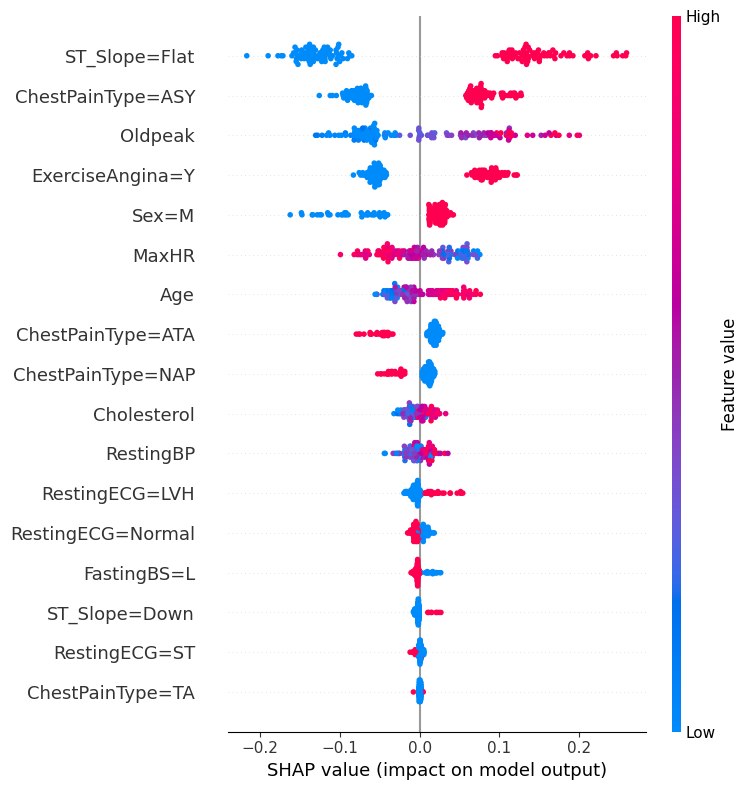

In [34]:
# SHAP Summary Plot (global)
shap.summary_plot(shap_values[..., 1], X_test,feature_names)

Hay muchos puntos en este gráfico. Cada punto tiene 3 características:

+ su posicion vertical nos dice a que 'feature' se refiere, se presentan ordenados de mayor a menor por la suma de los valores de los SHAP values de cada 'feature' sumados sobre todos les pacientes, 
+ su color muestra si el valor de la 'feature' es alto (rojo) o bajo (azul) por eso para las variables binarias que no tienen valores intermedios no hay puntos de color violeta , y
+ su posicion horizontal muestra si el efecto de ese valor causó que el valor de predicción cruda ('raw score') subiera o bajara.

Por ejemplo, el punto de más arriba a la izquierda corresponde a une paciente con muy bajo valor de la característica 'ST_Slope=Flat' que contribuyó bastante a su bajo 'raw score'. Si miramos 'Sex=M', los puntos rojos (que corresponden a 'Sex=M=1', es decir, son hombres) están todos bastante juntos en la zona de riesgo, mientras que los puntos de las mujeres se ditribuyen más y en la zona de no riesgo, lo cual nos indica que los valores de la 'feature' 'ser mujer ('Sex=M=0') en muchos casos contribuyeron a un bajo 'raw score'.  

En el manual de SHAP se explica también como crear 'Dependence plots' y otras gráficas interesantes.

Es importante resaltar que este tipo de análisis donde se calculan los Shapley values para todas las predicciones pueden ser computacionalmente costosos cuando el conjunto de datos es mayor. Por eso SHAP calcula Shapley values aproximados, tomando un subconjunto de las predicciones seleccionado aleatoriamente ('random resampling'). Esta es una de las limitaciones. Para entender en profundidad los valores Shapley recomendamos el maravilloso libro gratuito de Christopher Molnar [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/). También podemos profundizar en más limitaciones de los valores de Shapley en este artículo ["The Inadequacy of Shapley Values for Explainability"](https://arxiv.org/pdf/2302.08160). Christopher Molnar ha creado un nuevo paquete llamado `shapiq` que tiene en cuenta la interacción de las 'features' [What Are Shapley Interactions, and Why Should You Care?](https://mindfulmodeler.substack.com/p/what-are-shapley-interactions-and), es decir, tiene encuenta las contribuciones de cada "feature" tanto dentro de las posibles coaliciones como sus contribuciones individuales. Sin embargo, no trataremos estos aspectos aquí y pasaremos a otro método de adición de contribuciones para prediciones individuales pero basado en un modelo subrogado. 

<a name='xai-lime'/>

### <font color=#ac6240>4.3 LIME</font>

_'Local interpretable model-agnostic explanations'_ [LIME](https://github.com/marcotcr/lime) es el nombre del artículo donde las autoras proponían una implementación concreta de modelos locales subrogados para explicar el comportamiento local de cualquier modelo de aprendizaje automatico. 

Como dijimos, los modelos subrogados son modelos interpretables ('glass-boxes') que entrenamos con los mismos datos que usamos para entrenar el modelo de aprendizaje automático que queremos explicar pero usando como variable de destino o 'target' las predicciones que hizo ese modelo de aprendizaje automático que queremos explicar. 

El modelo subrogado que usa LIME por defecto en su implementación en Python es la Ridge Linear Regression, que como dijimos en la sección <a href=#project-description-intro>1.1 Introducción</a>, es interpretable. Para las tareas de clasificación, como la nuestra, la regresión lineal se entrena sobre las 'raw scores' que arrójo el modelo opaco (si hubiera más de dos clases, se entrena una regresión lineal separada para cada clase). Para las tareas de regresión, la regresión lineal se entrena directamente sobre los valores las predicciones del modelo opaco. 

Si las prediciones del modelo subrogado encajan con las predicciones del modelo opaco, podemos usar el modelo surrogado como proxy para explicar el comportamiento de la 'black box'. En el ejemplo de la clasificación de lobes y Huskies de la sección <a href=#project-description-intro>1.1 Introducción</a>, el modelo lineal basó su predicción en los pixeles de la nieve de la foto, por eso deducimos que la red neuronal hizo lo mismo.

La SIPA de LIME es:

+ Toma una instancia (une paciente) de los datos del conjunto de entrenamiento 
+ Perturba los datos para generar un espacio de instancias cercanas (es decir, simula varies pacientes con caracteristícas similares a ese paciente)
+ Predice, es decir, aplica el bosque aleatorio a cada una de las instancias de ese espacio local (les nueves pacientes simulades)
+ Entrena un modelo de regresión lineal para predecir esas predicciones.

[Bea Hernández](https://charlas.2022.es.pycon.org/pycones2022/talk/3TKTHE/) en su charla de la PyConES22 _"Explicabilidad local: ¿cómo interpreto la predicción?"_, que puede verse en la lista de reproducción del canal de youtube de Python España, también explica LIME.

Usaremos LIME para explicar una predicción cualquiera de nuestro bosque aleatorio. Cabe destacar que LIME se puede aplicar en clasificaciones y en regresiones y no solo para datos tabulares sino también para explicar la predición modelos de aprendizaje automático aplicados a series temporales, imágenes, textos con Natural Lenguage Processing [NLP](https://en.wikipedia.org/wiki/Natural_language_processing), y otras tareas. Por ejemplo, en la siguiente foto, el modelo de aprendizaje automático de clasificación de imágenes predijo 'gato' y LIME explica qué pixels usó el modelo de aprendizaje automático (en verde) y cuáles descartó (en rojo).

![LIME](./images/LIME.png "LIME")

[Fuente de la imagen](https://github.com/marcotcr/lime)

Como en la sección anterior cuando explicamos los 'Shapley values', tampoco hace falta volver a entrenar nuestro modelo de aprendizaje automático, ya lo entrenamos sobre el conjunto de entrenamiento y podemos ademas usar el mismo paciente que usamos allí y la 'raw score' que calculamos ya, por eso líneas de código de la celda siguiente están comentadas:

In [35]:
patient_number = 2 # just for the example, it could be any other patient
individual_prediction_array = df_X_test.iloc[patient_number].values.reshape(1, -1)
prediction = RF.predict_proba(individual_prediction_array)[0][1].round(2)
print("Prediction risk of heart disease:", prediction)
print("Actual risk of heart disease:    ", y_test[patient_number])

Prediction risk of heart disease: 0.69
Actual risk of heart disease:     1


creamos ahora el 'explainer' de LIME"

In [36]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, mode='classification', 
                                        feature_names = feature_names, 
                                        class_names = ['HeartDisease=0', 'HeartDisease=1'])

In [37]:
explanation = explainer.explain_instance(individual_prediction_array[0], 
                                 RF.predict_proba, num_features = len(feature_names))

In [38]:
explanation.show_in_notebook(show_table = True, show_all = False)

Primero se muestra la predicción del modelo de aprendizaje automático para ese paciente. Luego a su derecha la explicación de cuanto contribuyó cada 'feature' para que nuestro bosque aleatorio lo clasificara con una 'raw score' de ~0.69 (en naranja):
+ el valor de su 'ST_Slope=Flat' fuera positivo contribuyó un 0.29,
+ el valor de su 'Oldpeak' fuera mayor de 1.5 contribuyó 0.15,
+ ... y así con el resto de 'features'


En azul se muestran las contribuciones para el 'raw score' complementario de ~0.31. Debajo se muestra el valor de las 'features' de le paciente cuya predicción estamos explicando, solo aparecen aquellas que LIME encontró más relevantes para la explicación porque establecimos `show_all = True` en la función `show_in_notebook`.

Como hicimos en la sección de SHAP, veámos la explicación para el paciente que el modelo clasificó erróneamente:

In [39]:
patient_number = 12 
#print(df_X_test['Sex=M'].iloc[patient_number]) # to check the patient gender
individual_prediction_array = df_X_test.iloc[patient_number].values.reshape(1, -1)
prediction = RF.predict_proba(individual_prediction_array)[0][1].round(2)
print("Prediction risk of heart disease:", prediction)
print("Actual risk of heart disease:    ", y_test[patient_number])

Prediction risk of heart disease: 0.82
Actual risk of heart disease:     0


In [40]:
explanation = explainer.explain_instance(individual_prediction_array[0], 
                                 RF.predict_proba, num_features = 17)
explanation.show_in_notebook(show_table = True, show_all = False)

Vemos de nuevo que tanto para este paciente como para el paciente que fue clasificado como correctamente como en riesgo de fallo cardíaco:
+ el valor de su 'ST_Slope=Flat' fuera positivo contribuyó un 0.29, y
+ el valor de su 'Oldpeak' fuera mayor de 1.5 contribuyó 0.15,

es decir, parece que el bosque aleatorio clasifica como en riesgo a pacientes con estos valores de 'ST_Slope=Flat' y 'Oldpeak'. Cabe señalar que para las 'features' numericas (depués de la codificacion que hicimos en la sección <a href=#prep-encoding >2.3 Codificación y normalización de las 'features'</a>, todas lo son) LIME calcula su media y su desviación estándar y las discretiza en cuartiles, por eso en ambos pacientes la contribución máxima es 0.29 para 'ST_Slope=Flat' y 0.15 para 'Oldpeak'. Si hubiera 'features' categóricas, LIME calcula la frecuencia de cada valor. 

Hemos visto que SHAP y LIME son métodos de atribución donde las contribuciones de las 'features' se suman. Sin embargo, no sirven para explorar situaciones 'what-if'. Veamos ahora un método para hacerlo basado en ejemplos, es decir 'example-based'.

<a name='xai-counterfact'/>

### <font color=#ac6240>4.4 Counterfactual Explanations</font>

En lógica [“contrafáctico”](https://es.wikipedia.org/wiki/Contrafactual) (o ‘counterfactual’ en inglés), se refiere a un acontecimiento hipotético que pudo ser posible en un universo paralelo donde se tomaron otras decisiones.

Como método de XAI, las 'conterfactual explanations' son como los métodos descritos anteriormente: variaremos los valores de las features de une paciente y veremos cómo cambian la predicción. Ahora bien, esta vez nos centraremos en encontrar cuál es el mínimo cambio en las 'features' que produce un cambio significativo en la predicción, como:

+ un cambio de clase (de ser clasificadx como ‘HeartDisease=0’ a ser clasificado como ‘HeartDisease=1’), o 
+ que la ‘raw score’ alcance cierto umbral (por ejemplo, que la probabilidad heurística de pertenecer al grupo con riesgo de sufrir un fallo cardiaco sea menor del 30%)

o cualquier resultado que deseemos. Es decir, para el primer ejemplo, dade une paciente clasificade como ‘HeartDisease=1’, qué es lo más sencillo que puede hacer ese paciente para abandonar el grupo de las personas en riesgo de fallo cardíaco? Explicaciones contrafácticas relativas a cambios en el sexo o disminución de la edad no serán muy útiles, pero una ‘counterfactual explanation’ como ‘si baja su colesterol un 5% ese paciente pasará a ser clasificade como fuera de riesgo’ si son factibles y pueden ayudar a la recuperación de pacientes y a la prevención de fallo cardíaco.

Para entender en profundidad cómo se calculan las ‘counterfactual explanations’, recomendamos de nuevo el libro de Christoph Molnar, sección [9.3 Counterfactual Explanations](https://christophm.github.io/interpretable-ml-book/counterfactual.html). Aquí calcularemos las las ‘counterfactual explanations’ con la librería `DiCE` ('Diverse Counterfactual Explanations'). Para más información, este es [su manual para Scikit Learn](https://github.com/interpretml/DiCE). Veréis que `DiCE` se puede aplicar a la clasificación de imágenes y otras tareas que no son solo para datos tabulares.

In [41]:
# 1. prepare data for DiCE, it requires a dataframe with features and target together

# TEST
test_dataset = df_X_test.copy()
test_dataset['heart_disease'] = df_test.HeartDisease

#TRAIN
train_dataset = pd.DataFrame(X_train,columns = feature_names)
train_dataset['heart_disease'] = y_train

# create DiCE data objet
d = dice.Data(dataframe = train_dataset, 
                  continuous_features= numerical, 
                  outcome_name = 'heart_disease')

In [42]:
# 2. prepare model for DiCE using sklearn backend, it also supports Tensorflow and Pytorch

m = dice.Model(model = model, model_type='classifier', backend="sklearn")

In [43]:
# 3. initialize DiCE, it supports three methods for sklearn models: 
# random sampling, genetic algorithm search, and kd-tree based generation

exp = dice.Dice(d, m, method="random")

In [44]:
# select a individual prediction
patient_number = 2 # just for the example, it could be any other patient
individual_prediction = df_X_test[patient_number : (patient_number + 1)] #we need a pd.Dataframe
individual_prediction

Age  RestingBP  Cholesterol  MaxHR  Oldpeak  ChestPainType=ASY  \
2  55.0      160.0        292.0  143.0      2.0                0.0   

   ChestPainType=ATA  ChestPainType=NAP  ChestPainType=TA  ExerciseAngina=Y  \
2                1.0                0.0               0.0               1.0   

   FastingBS=L  RestingECG=LVH  RestingECG=Normal  RestingECG=ST  \
2          0.0             0.0                1.0            0.0   

   ST_Slope=Down  ST_Slope=Flat  Sex=M  
2            0.0            1.0    1.0

In [45]:
individual_prediction_array = df_X_test.iloc[patient_number].values.reshape(1, -1)
prediction = RF.predict_proba(individual_prediction_array)[0][1].round(2)
print("Prediction risk of heart disease:", prediction)
print("Actual risk of heart disease:    ", y_test[patient_number])

Prediction risk of heart disease: 0.69
Actual risk of heart disease:     1


Es decir, este paciente fue clasificado por el bosque aleatorio como en riesgo de sufrir un fallo cardíaco y la predicción es correcta. Veamos la explicación de la predicción:

In [46]:
explicacion = exp.generate_counterfactuals(individual_prediction, 
                                  total_CFs=3, # for 3 counterfactual explanations
                                  features_to_vary=['RestingBP', 'Cholesterol','MaxHR'],
                                  desired_class="opposite") # so 'HeartDisease' would be 0 

100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


In [47]:
explicacion.visualize_as_dataframe(show_only_changes=True) #highlights the changes from the query instance. 
#If you would like to see the full feature values for the counterfactuals, set it to False.

Query instance (original outcome : 1)


Age  RestingBP  Cholesterol  MaxHR  Oldpeak  ChestPainType=ASY  \
0  55.0      160.0        292.0  143.0      2.0                0.0   

   ChestPainType=ATA  ChestPainType=NAP  ChestPainType=TA  ExerciseAngina=Y  \
0                1.0                0.0               0.0               1.0   

   FastingBS=L  RestingECG=LVH  RestingECG=Normal  RestingECG=ST  \
0          0.0             0.0                1.0            0.0   

   ST_Slope=Down  ST_Slope=Flat  Sex=M  heart_disease  
0            0.0            1.0    1.0              1


Diverse Counterfactual set (new outcome: 0)


Age RestingBP Cholesterol  MaxHR Oldpeak ChestPainType=ASY  \
0   -     117.6       186.2  161.6       -                 -   
1   -      94.3       158.2  176.4       -                 -   
2   -     117.3       118.9  200.4       -                 -   

  ChestPainType=ATA ChestPainType=NAP ChestPainType=TA ExerciseAngina=Y  \
0                 -                 -                -                -   
1                 -                 -                -                -   
2                 -                 -                -                -   

  FastingBS=L RestingECG=LVH RestingECG=Normal RestingECG=ST ST_Slope=Down  \
0           -              -                 -             -             -   
1           -              -                 -             -             -   
2           -              -                 -             -             -   

  ST_Slope=Flat Sex=M heart_disease  
0             -     -           0.0  
1             -     -           0.0  
2             -     -           0.0

Los 3 ejemplos que obtenemos corresponden a pacientes (del universo paralelo) que consiguieron pasar de ser clasificades como 'HeartDisease=1' a ser clasificades como 'HeartDisease=0' gracias a que bajaron sus valores de 'RestingBP', 'Cholesterol', a pesar de que su máximo ritmo cardíaco 'MaxHR' era más alto. Y  las 'counterfactual explanations' nos dicen cómo de grande ha de ser esa reducción.

No hemos incluido la posibilidad de cambios en 'ST_Slope=Flat' porque ya sabemos que es una 'feature' muy relevante y las 'counterfactual explanations' nos dan pacientes con cualquier valor de las otras 'features' con tal que 'ST_Slope=Flat' pase de '1' a '0'. Tampoco permitimos cambios en 'Age' y 'Sex' porque ya vimos que les pacientes más jovenes y/o las nacidas mujer tienen más probabilidad de pertenecer al grupo de les pacientes sin riesgo de sufrir fallo cardíaco, pero son 'features' que no pueden cambiarse. Puedes modificar la lista de 'features_to_vary' para sacar tus propias conclusiones.

<font size="5"> 👍🤓 </font>

Vemos que las explicaciones contrafácticas son métodos locales porque se usan para intentar explicar una predicción individual, en nuestro caso, el resultado de la clasificación de une paciente en concreto. La librería `DiCE` también ofrece herramientas para calcular 'Counterfactual Explanations' para todes les pacientes y ver que 'features' son más relevantes para ese modelo de aprendizaje automático de manera global. 

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='xai-end'/>

### <font color=#ac6240>5. Conclusión sobre los métodos de explicabilidad</font>

Hemos aplicado diferentes métodos para explicar las predicciones de nuestro bosque aleatorio.

Parece que la característica 'ST_Slope' es muy significativa y explica gran parte de los 'raw scores' obtenidos para cada clasificación. Esto corrobora lo aprendido durante la exploración de los datos en el anterior Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI) donde durante la exploración de los datos vimos que las características numéricas 'Oldpeak, y 'MaxHR', y las categóricas 'ST_Slope', 'ExerciseAngina' y 'ChestPainType' eran las que más se correlacionaban con la variable de destino 'HeartDisease'. Si las técnicas de XAI nos hubieran dicho que el bosque aleatorio basaba sus predicciones mayoritariamete en los valores de una 'feature' como 'RestBP' o algo que les expertes en medicina saben que no es relevante (como la nieve al fondo de la foto de nuestre perre Husky de la introducción) habriamos detectado 'leakage'. 

Además, vemos que la mayoría de las personas en riesgo de fallo cardíaco tienen 'ST_Slope' con valor 'Flat' y a menudo también tienen 'Oldpeak' mayor de 1.5. El bosque aleatorio clasifica como en riesgo a las personas con uno de esos valores, o ambos, y un ~10% de las veces se equivoca, porque hay personas con  'ST_Slope=Flat' y 'Oldpeak' mayor de 1.5 que _no están en riesgo_, pero nuestro modelo de aprendizaje automático no es capaz de resolverlos correctamente. 

Por tanto la explicabiliad identificó cuantitativamente los puntos fuertes y débiles de nuestro bosque aleatorio para poder compartirlos con les expertes en medicina y poder comprobar que las predicciones tienen sentido.

<font size="5">🎈♫♫🎈🎈♫🎈♫♫♫♫🎈🎈 ♫♫♫ 🎈🎈</font>

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<font size="5">☀️⛱️ </font> Buen trabajo! Despues de un descanso, quizá quieras continuar el análisis con el siguiente Jupyter Notebook de la serie, contiene una introducción a varios métodos cuantificacion de incertidumbre ([UQ](https://en.wikipedia.org/wiki/Uncertainty_quantification)), se llama `UQ.ipynb` y se encuentra también en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI).

De hecho, puede aplicarse UQ a los resultados de la XAI, como en este artículo: [But Are You Sure? An Uncertainty-Aware Perspective on Explainable AI](https://proceedings.mlr.press/v206/marx23a/marx23a.pdf) o estos trabajos donde se cuantiza la incertidumbre Predicción Conforme, el método de UQ que explicamos en el siguiente Jupyter Notebook, para los valores de Shapley [Estimating Quality of Approximated Shapley Values Using Conformal Prediction](https://proceedings.mlr.press/v230/alkhatib24a.html), los contrafactuales [Training calibration-based counterfactual explainers for deep learning models in medical image analysis](https://www.nature.com/articles/s41598-021-04529-5) y todo tipo de XAI con este paquete [Calibrated Explanations](https://github.com/Moffran/calibrated_explanations).